<a href="https://colab.research.google.com/github/hoangxtr/form_detection/blob/master/rotate_one_form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

clear_output()

In [ ]:
# %cd /content/
# !gdown --id 1I0_oQcyiKS9TRCNNGzHvNFsamnLLRxFB

# !unzip /content/Annotated-20210812.zip
# !rm /content/Annotated-20210812.zip

# clear_output()

In [ ]:
# !gdown --id 1-WeaSrUIlHW8Pj0woXwd719zILuabhIJ
# !unzip 201-300.zip

# clear_output()

In [ ]:
! git clone https://github.com/xingyizhou/CenterNet2
!gdown --id 1VpCSyUFoKB4UHYVftUxTa8c0PWLZ5DUF -O /content/Shipping_label_LVIS_R50_hybrid.yaml

%cd /content/CenterNet2/projects/CenterNet2/

Cloning into 'CenterNet2'...
remote: Enumerating objects: 11053, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 11053 (delta 65), reused 144 (delta 60), pack-reused 10888
Receiving objects: 100% (11053/11053), 4.62 MiB | 14.55 MiB/s, done.
Resolving deltas: 100% (7958/7958), done.
Downloading...
From: https://drive.google.com/uc?id=1VpCSyUFoKB4UHYVftUxTa8c0PWLZ5DUF
To: /content/Shipping_label_LVIS_R50_hybrid.yaml
100% 858/858 [00:00<00:00, 738kB/s]
/content/CenterNet2/projects/CenterNet2


In [ ]:
import atexit
import bisect
import multiprocessing as mp
from collections import deque
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import json

plt.rcParams["figure.figsize"] = (30,15)

from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor

from detectron2.config import get_cfg
from centernet.config import add_centernet_config

In [ ]:
def centernet2_detect(predictor, image) :
    predictions = predictor(image)['instances']
    bboxes = predictions.pred_boxes.tensor.cpu().numpy()
    keypoints = predictions.pred_keypoints.cpu().numpy()
    # print('pred box ', bboxes)
    # print('pred score', predictions.scores.cpu().numpy())
    # print('pred keypoints', keypoints)
    detect_sl = []
    for box,keypoint in zip(bboxes,keypoints):
        # idx += 1
        x1,y1,x2,y2 = np.array(box, dtype=np.int32)
        if y1 >= y2 or x1 >= x2 :
            continue
        crop_image = image[y1:y2,x1:x2,:]
        skip_rectify = False
        for score_kp in keypoint[:,2]:
            if score_kp <= 0.4 :
                result_image = crop_image
                detect_sl.append(result_image)
                skip_rectify = True
                break
        if skip_rectify :
            continue
        tl, tr, bl, br = keypoint[:,:2] - np.array([x1,y1])
        height, width,_ = crop_image.shape
        all_kps = [tl, tr, bl, br]
        return_box = False
        for  i in range(len(all_kps) - 1):
            stop = False
            for j in range(i+1,len(all_kps)):
                p1 , p2 = all_kps[i], all_kps[j]
                distance = np.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))
                if distance < 0.2 * min(width,height) :
                    stop = True
                    return_box = True
            if stop :
                break
        if return_box:
            detect_sl.append(crop_image)
            continue
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],                         
            [maxWidth - 1, 0],            
            [maxWidth - 1, maxHeight - 1], 
            [0, maxHeight - 1]],         
            dtype = "float32"          
        )
       
        M = cv2.getPerspectiveTransform(np.array([tl, tr, br, bl], dtype = "float32" ), dst)
        result_image = cv2.warpPerspective(crop_image, M, (maxWidth, maxHeight))
        detect_sl.append(result_image)
    return detect_sl

In [ ]:
def setup_cfg(model_path, conf_thresh=0.3):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_centernet_config(cfg)
    cfg.merge_from_file(CONFIG_PATH)
    # cfg.merge_from_list(args.opts)
    cfg.MODEL.WEIGHTS = model_path
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = conf_thresh
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = conf_thresh
    if cfg.MODEL.META_ARCHITECTURE in ['ProposalNetwork', 'CenterNetDetector']:
        cfg.MODEL.CENTERNET.INFERENCE_TH = conf_thresh
        cfg.MODEL.CENTERNET.NMS_TH = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = conf_thresh
    cfg.freeze()
    return cfg

In [ ]:
def resize_keep_origin_ratio(img, width=1600, height=1120):

    # return img

    img = img.copy()
    h,w = img.shape[:2]
    img_ratio = h/w
    aspect_ratio = height/width
    if aspect_ratio > img_ratio:
        resized_width = width
        resized_height = int(resized_width * img_ratio)
    else:
        resized_height = height
        resized_width = int(resized_height / img_ratio)
    img = cv2.resize(img, (resized_width, resized_height), cv2.INTER_AREA)
    return img

In [ ]:
temp_keypoint = np.array([0,0,0,2,2,2,2,0]).reshape(-1,1,2)


cv2.contourArea(temp_keypoint)

4.0

In [ ]:
def process(predictor, img, sep_form=True,  use_mapping=False, check_slope=False):
  '''
  Param:
    predictor: DefaultPredictor of detectron2
    sep_form: crop forms or only vizualize
    use_mapping: use mapping algorithm for keypoint and segmented mask or not
    check_slope: check slope of croped form or not
  '''
  img = img.copy()
  predictions = predictor(img)
  predictions = predictions['instances'].to('cpu:0')
  all_forms = []
  
  for i in range(len(predictions)):
    bboxes = predictions[i].pred_boxes.tensor.cpu().numpy()
    keypoints = predictions[i].pred_keypoints.cpu().numpy()
    if use_mapping:
      keypoints = keypoints[0][:, :2].astype(np.int32)
      min_rect = cv2.minAreaRect(keypoints.reshape(-1,1,2))
      temp_box = cv2.boxPoints(min_rect) # (4,2)
      s1 = cv2.contourArea(keypoints.reshape(-1,1,2))
      s2 = cv2.contourArea(temp_box.reshape(-1,1,2))
      if  min(s1,s2)/max(s1,s2) < 4/5 :
        print('mapping use')
        mask = predictions[i].pred_masks.numpy()[0]
        box = mask2box(mask)
        keypoints = [matching_keypoint(box, keypoints)]


    # print(keypoints)
    scores = predictions[i].scores.cpu().numpy()
    if sep_form:
      all_forms.append(crop_form(img, bboxes, keypoints, check_slope))
    else:
      img = viz_instance(img, bboxes, keypoints, scores)
  if sep_form:
    return all_forms
  return img

In [ ]:
def viz_instance(img, bboxes, keypoints, scores):
  # print('______________________________________________________________________-')
  img = img.copy()
  for bbox, keypoint, score in zip(bboxes, keypoints, scores):
    x1,y1,x2,y2 = np.asarray(bbox, dtype=np.int32)
    # print((x1,y1,x2,y2))
    img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 4)
    point_color = [50,100,200]
    for i, point in enumerate(np.round(keypoint)):
      # point_color = (255,0,0) if point[2] == 1 else (0,0,255)
      if point[0] > img.shape[1] or point[0] < 0 or point[1] > img.shape[0] or point[0] < 0:
        print('Case nay sai ne')
      # print(f'i: {i}\npoint: {point}\n')
      img = cv2.circle(img, (point[0], point[1]), 20, COLOR_LIST[i], -1)
      img = cv2.putText(img, TEXT_LIST[i], (point[0], point[1]), cv2.FONT_HERSHEY_COMPLEX, 2, COLOR_LIST[i], 2)
    img = cv2.putText(img, "{:.2f}".format(score), (x1,y1), cv2.FONT_HERSHEY_COMPLEX, 3, (10,62,138), 3)
  return img

In [ ]:
def viz_form(form_list, index):
  bbox_img = form_list[index][0]
  rotate_img = form_list[index][1]

  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(20, 10)
  ax[0].imshow(bbox_img)
  ax[0].set_title('bbox result')
  ax[1].imshow(rotate_img)
  ax[1].set_title('rotated result')

In [ ]:
def crop_form(img, bboxes, keypoints, check_slope=False):
  rets = []
  # print('start')
  for bbox, keypoint in zip(bboxes, keypoints):
    x1,y1,x2,y2 = np.asarray(bbox, dtype=np.int32)
    # print(f'{[x1,x2,y1,y2]}\n{keypoint}')
    # print('\n')
    crop_img = img[y1:y2, x1:x2, :].copy()
    w,h = crop_img.shape[:2]
    keypoint = np.round(keypoint)
    tl,tr,bl,br = keypoint[:, :2] - np.array([x1,y1]).reshape(1,2)
    width1 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    width2 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    max_width = int(max(width1, width2))

    height1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = int(max(height1, height2))

    dst = np.array([[0,0], [max_width -1, 0], [max_width-1, max_height-1], [0,max_height-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(np.array([tl, tr, br, bl], dtype='float32'), dst)
    ret_img = cv2.warpPerspective(crop_img.copy(), M, (max_width, max_height))
    if check_slope: 
      ret_img = rotate_form(ret_img)

    for i, point in enumerate(np.asarray([tl,tr,bl,br], dtype=np.int32)):
      # point_color = (255,0,0) if point[2] == 1 else (0,0,255)
      crop_img = cv2.circle(crop_img, (point[0], point[1]), 20, COLOR_LIST[i], -1)
      crop_img = cv2.putText(crop_img, TEXT_LIST[i], (point[0], point[1]), cv2.FONT_HERSHEY_COMPLEX, 2, COLOR_LIST[i], 2)
    
    rets += [[crop_img, ret_img]]
  # print('end')
  return rets[0]



In [ ]:
def matching_keypoint(box, keypoints):
  '''
  Param:
    - box: 4 corner in clockwise in shape (4,2) (a,b,c,d) [0,3,0,1] 
    - keypoints: [tl,tr,bl,br]
  Return
    box in order tl,tr,bl,br

    bcda
    bcda
    cdab
    abcd
  '''
  scores = [0,0,0,0]
  keypoints[[2,3]] = keypoints[[3,2]]
  for i, keypoint in enumerate(keypoints):
    distances = np.linalg.norm(box-keypoint.reshape(-1,2), axis=1)
    pos = np.argmin(distances) - i
    if pos < 0: pos += 4
    scores[pos] += 1
  pos = np.argmax(scores)
  ret = [box[(i+pos)%4] for i in range(4)]
  ret[2],ret[3] = ret[3], ret[2]
  return ret

In [ ]:
def mask2box(mask):
  gray_mask = np.asarray(mask, dtype=np.uint8) * 255
  _, bin_mask = cv2.threshold(gray_mask, 100, 255, cv2.THRESH_BINARY)
  canny = cv2.Canny(bin_mask, 50, 100)
  cnts, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = np.concatenate(cnts, 0)
  rect = cv2.minAreaRect(cnts)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  box[:, 0] = np.clip(box[:, 0], a_min=0, a_max=np.max(box[:,0]))
  box[:, 1] = np.clip(box[:, 1], a_min=0, a_max=np.max(box[:,1]))
  return box

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
  
def rotate_form(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  h,w = gray.shape
  canny = cv2.Canny(img, 100, 200)
  dilate = cv2.dilate(canny, np.ones((3,3)), iterations=10)
  lines = cv2.HoughLinesP(dilate, 1, 5*np.pi/180, 200, minLineLength=w/10)
  lines = np.squeeze(lines)
  slopes = np.arctan2(lines[:, 3]-lines[:, 1], lines[:,2]-lines[:,0])*180/np.pi
  clusters = []

  for slope in slopes:
    added = False
    for cluster in clusters:
      if np.abs( np.mean(cluster) - slope ) <= 5:
        cluster.append(slope)
        added = True
        break
    if not added:
      clusters.append([slope])
  angle = round(np.mean(clusters[np.argmax(list(map(lambda x: len(x), clusters)))]))
  if np.abs(angle) > 2:
    print('rotated')
    print(f'angle: {angle}')
    return rotate_image(img, angle)
  return img

In [ ]:
# !ls '/content/drive/MyDrive/Copy of FormDetectionData/new_300forms_save_folder/mask/model_0040999.pth'

In [ ]:
# IMAGE_PATH = '/content/Annotated-20210812/Quang Tran (1-15)/1-15Photo Annotate/images/3.jpg'
IMAGE_PATH = '/content/201-300/255.jpg'
IMAGE_PATH = '/content/drive/MyDrive/Create_Data_Vendor_forms/63.jpg'
# HOANG_MODEL_PATH = "/content/drive/MyDrive/Copy of FormDetectionData/model/hoang_model_0019999.pth"
HOANG_MODEL_PATH = "/content/drive/MyDrive/Copy of FormDetectionData/300forms_save_folder/model_0046499.pth"
HOANG_MODEL_PATH = '/content/drive/MyDrive/Copy of FormDetectionData/new_300forms_save_folder/no_mask/model_0039499.pth'
HOANG_MODEL_PATH = '/content/drive/MyDrive/Copy of FormDetectionData/new_300forms_save_folder/mask/model_0040999.pth'
HOANG_MODEL_PATH = '/content/drive/MyDrive/Copy of FormDetectionData/new_300forms_save_folder/new_mask/model_0093999.pth'

LAM_MODEL_PATH = '/content/drive/MyDrive/Copy of FormDetectionData/model/model_0020999.pth'
CONFIG_PATH = '/content/Shipping_label_LVIS_R50_hybrid.yaml'
COLOR_LIST = [(255,255,0), (51,51,255), (255,51,153), (204,255,229)]
TEXT_LIST = ['TL', 'TR', 'BL', 'BR']

In [ ]:
lam_cfg = setup_cfg(LAM_MODEL_PATH, 0.5)
hoang_cfg = setup_cfg(HOANG_MODEL_PATH, 0.5)

lam_predictor = DefaultPredictor(lam_cfg)
hoang_predictor = DefaultPredictor(hoang_cfg)

Config '/content/Shipping_label_LVIS_R50_hybrid.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/content/Shipping_label_LVIS_R50_hybrid.yaml' has no VERSION. Assuming it to be compatible with latest v2.


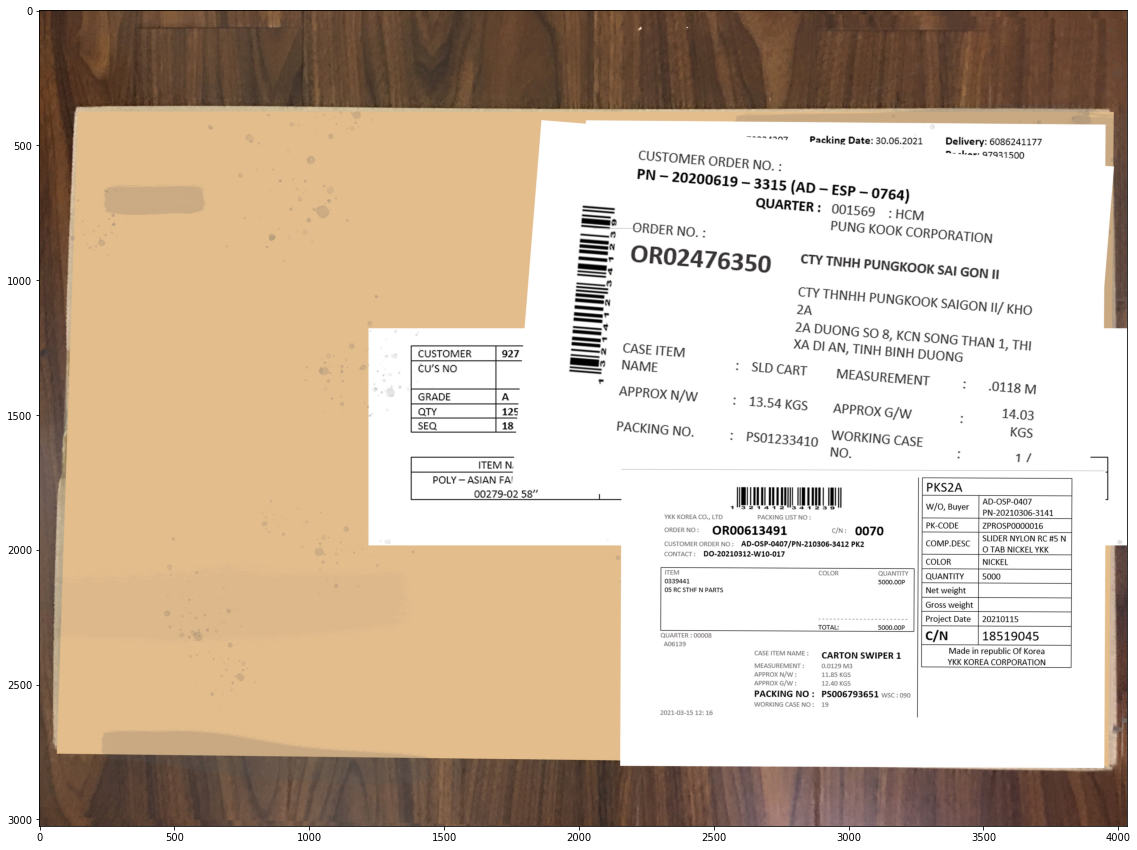

In [ ]:
img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = resize_keep_origin_ratio(img)
plt.imshow(img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# plt.imsave('/content/input/cut_form.jpg', img)

vizualize on image

In [ ]:
# print('lam process')
lam_ret_img = process(lam_predictor, img, sep_form=False, use_mapping=False, check_slope=False)
# print('hoang process')
hoang_ret_img = process(hoang_predictor, img, sep_form=False, use_mapping=False, check_slope=False)

/content/CenterNet2/projects/CenterNet2/centernet/modeling/dense_heads/centernet.py:567: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  per_candidate_nonzeros = per_candidate_inds.nonzero() # n


Text(0.5, 1.0, 'Hoang result')

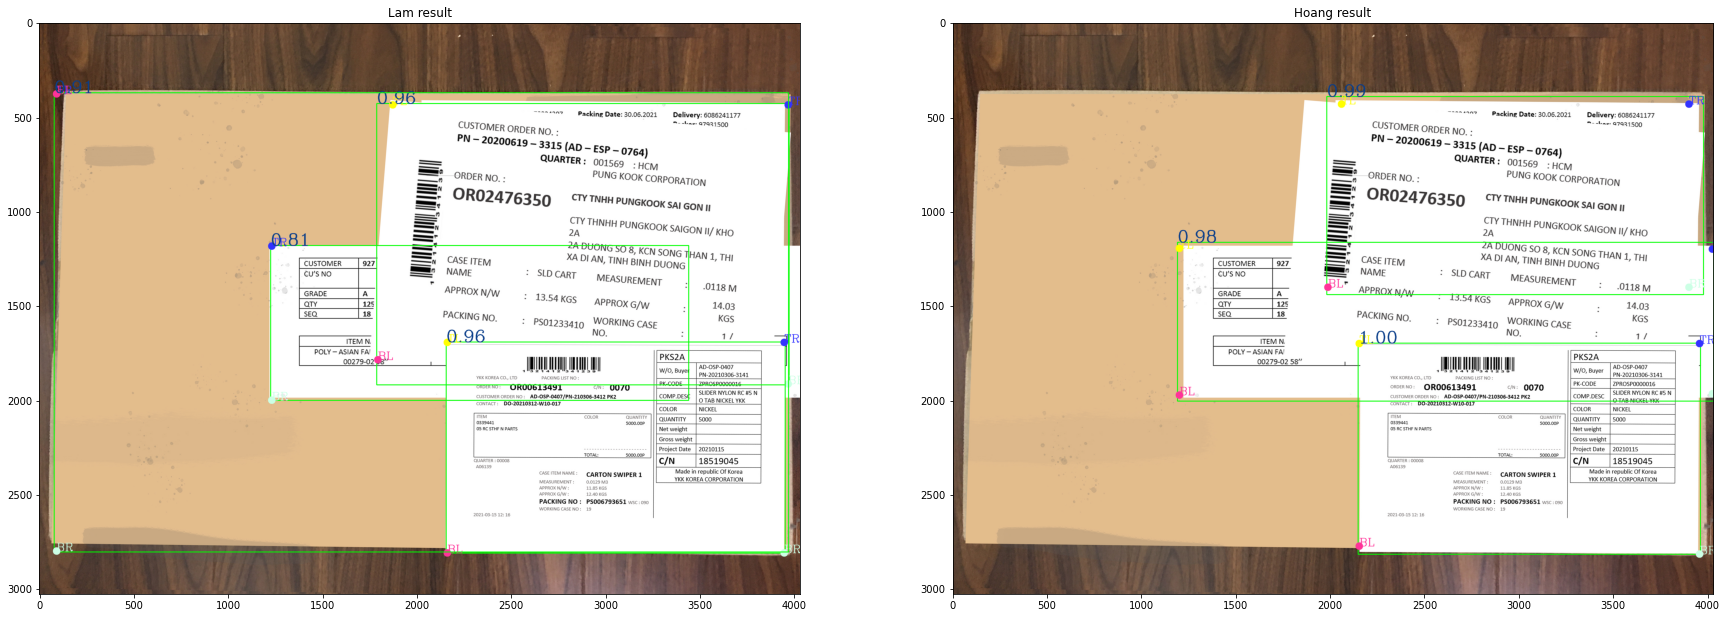

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(30, 20)
ax[0].imshow(lam_ret_img)
ax[0].set_title('Lam result')
ax[1].imshow(hoang_ret_img)
ax[1].set_title('Hoang result')

Cut form

In [ ]:
# print('lam process')
lam_ret_forms = process(lam_predictor, img, sep_form=True, use_mapping=False, check_slope=False)
print(f'Number form of old: {len(lam_ret_forms)}')
# print('hoang process')
hoang_ret_forms = process(hoang_predictor, img, sep_form=True, use_mapping=True, check_slope=True)
print(f'Number form of new: {len(hoang_ret_forms)}')


Number form of old: 4
mapping use
mapping use
mapping use
Number form of new: 3


New model


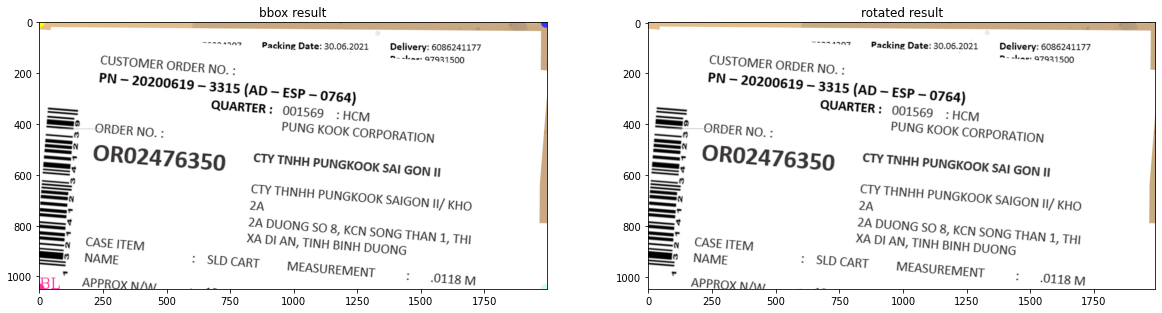

In [ ]:
temp_id = 1
try:
  print('New model')
  viz_form(hoang_ret_forms, temp_id)
  plt.show()
except:
  print('New model fail')

# try:
#   print('Old model')
#   viz_form(lam_ret_forms, temp_id)
#   plt.show()
# except:
#   print('Old model fail')

In [ ]:
round(0.1)

0

In [ ]:
round(-0.6)

-1

In [ ]:
start = 200
end = 220
n_col = 2
n_row = (end - start) // n_col

fig, ax = plt.subplots(n_row, n_col)
fig.set_size_inches(15*n_col, 10*n_row)
for i in range(start, end):
  index = (i - 2)%(end-start)
  img_path = f'/content/drive/MyDrive/Create_Data_Vendor_forms/{i}.jpg'
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  hoang_ret_img = process(hoang_predictor, img, False, True)
  ax[index//2][index%2].imshow(hoang_ret_img)
  ax[index//2][index%2].set_title(img_path)

### New test

In [ ]:
predictions = lam_predictor(img)
predictions = predictions['instances'].to('cpu:0')

In [ ]:
keypoints = predictions[1].pred_keypoints.numpy()[0][:, :2].astype(np.int32)
mask = predictions[1].pred_masks.numpy()[0]
box = mask2box(mask)

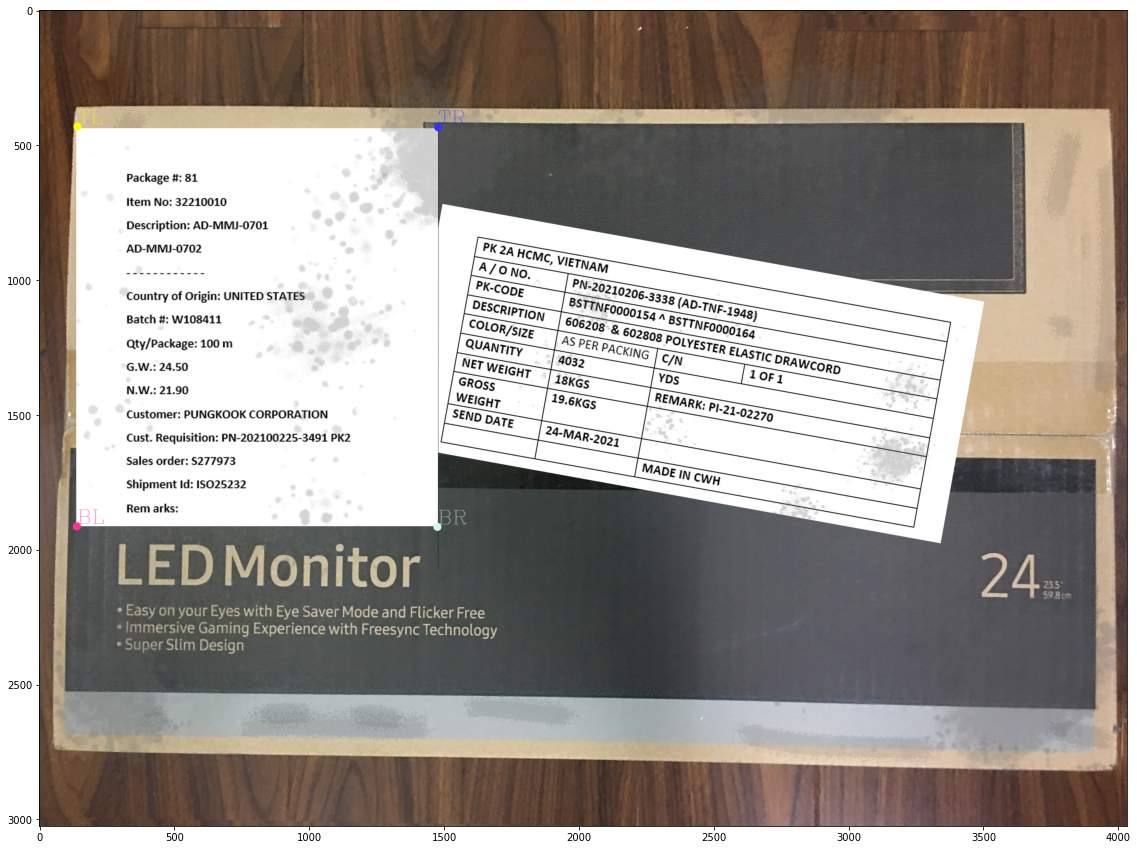

In [ ]:
# for pos in matching_keypoint(box, keypoints):
ret_img = img.copy()
for i, point in enumerate(matching_keypoint(box, keypoints)):
  ret_img = cv2.circle(ret_img, tuple(point), 15, COLOR_LIST[i], -1)
  ret_img = cv2.putText(ret_img, TEXT_LIST[i], (point[0], point[1]-10), cv2.FONT_HERSHEY_COMPLEX, 2.5, COLOR_LIST[i], 1)

plt.imshow(ret_img)


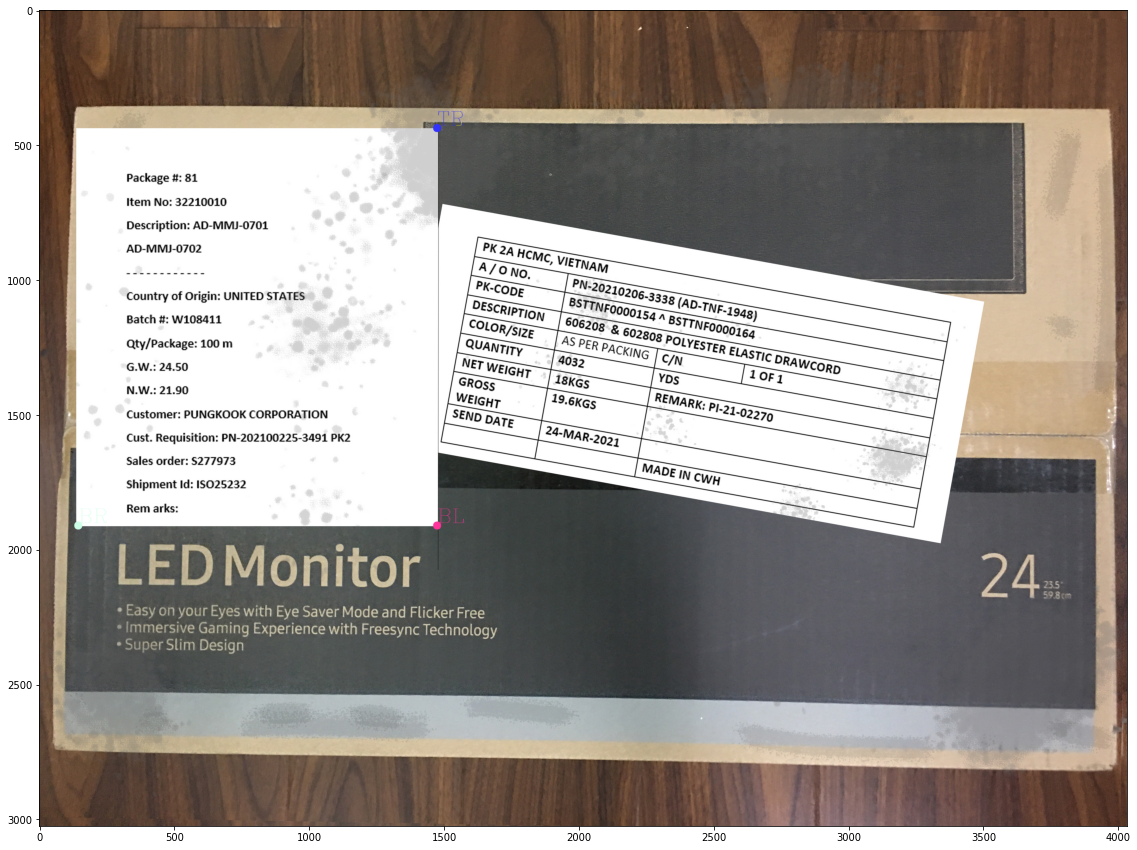

In [ ]:
ret_img = img.copy()
for i, point in enumerate(keypoints):
  ret_img = cv2.circle(ret_img, tuple(point), 15, COLOR_LIST[i], -1)
  ret_img = cv2.putText(ret_img, TEXT_LIST[i], (point[0], point[1]-10), cv2.FONT_HERSHEY_COMPLEX, 2.5, COLOR_LIST[i], 1)

plt.imshow(ret_img)

##### Segmentation

In [ ]:
def custom_resize(image, short_edge, long_edge) :
    h, w = image.shape[:2]
    scale = short_edge * 1.0 / min(h, w)
    if h < w:
        newh, neww = short_edge, scale * w
    else:
        newh, neww = scale * h, short_edge
    if max(newh, neww) > long_edge:
        scale = long_edge * 1.0 / max(newh, neww)
        newh = newh * scale
        neww = neww * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return cv2.resize(image,(neww,newh), interpolation = cv2.INTER_LINEAR)

In [ ]:
prediction = hoang_predictor(img)
prediction['instances'].get_fields().keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks', 'pred_keypoints', 'pred_keypoint_heatmaps'])

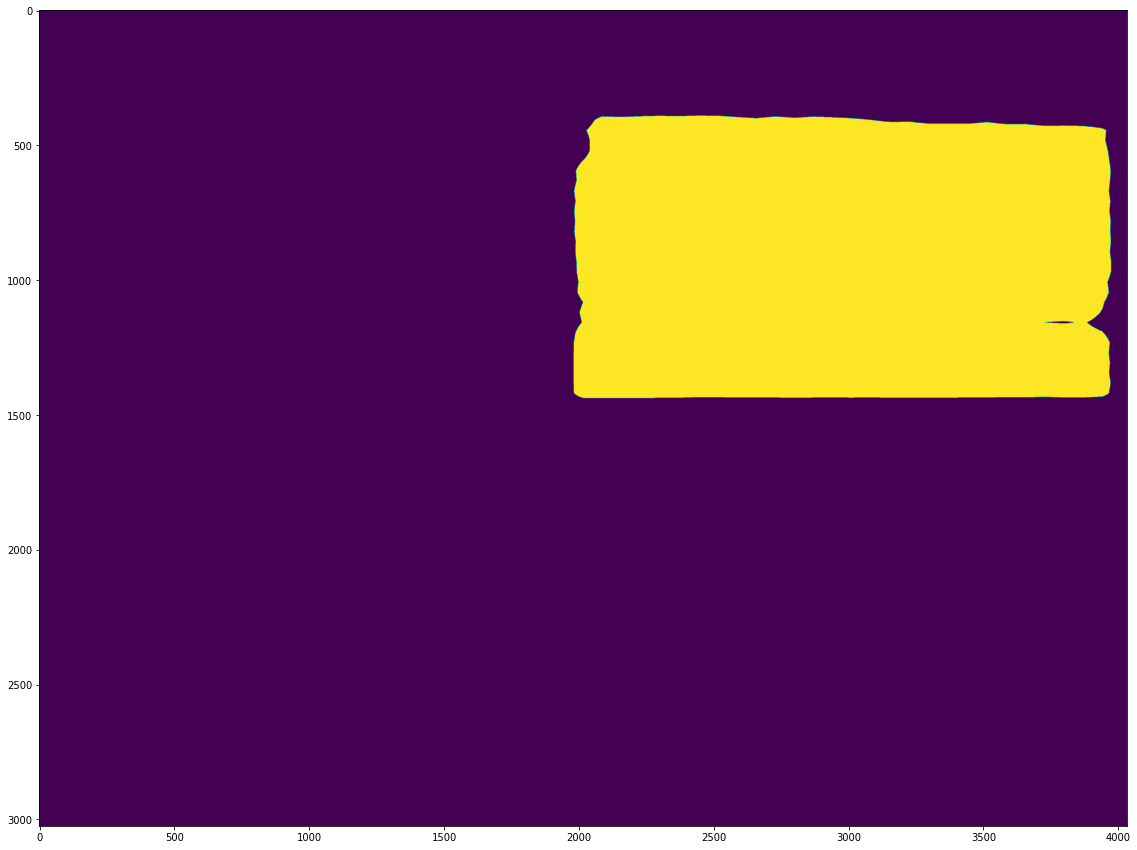

In [ ]:
plt.imshow(prediction['instances'].pred_masks[1].cpu().numpy())

In [ ]:
mask = prediction['instances'].pred_masks[0].cpu().numpy()

#### Test

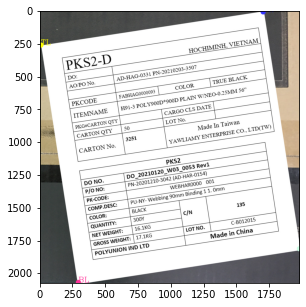

In [ ]:
plt.imshow(hoang_ret_forms[0][0])

In [ ]:
!mkdir /content/input/
plt.imsave('/content/input/cut_form.jpg', hoang_ret_forms[0][0])

mkdir: cannot create directory ‘/content/input/’: File exists


In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/NathanUA/U-2-Net.git
!gdown --id 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
!mkdir /content/input/

Cloning into 'U-2-Net'...
remote: Enumerating objects: 868, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 868 (delta 143), reused 218 (delta 123), pack-reused 604
Receiving objects: 100% (868/868), 36.41 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (389/389), done.
Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/u2net.pth
100% 176M/176M [00:01<00:00, 96.4MB/s]
mkdir: cannot create directory ‘/content/input/’: File exists


In [ ]:
%cd U-2-Net/
!pip install -r requirements.txt

In [ ]:
!cp '/content/drive/MyDrive/Create_Data_Vendor_forms/6.jpg' '/content/input/cut_form.jpg'

In [ ]:
!python u2net_test.py

['/content/input/cut_form.jpg']
...load U2NET---173.6 MB
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
inferencing: cut_form.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-package

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

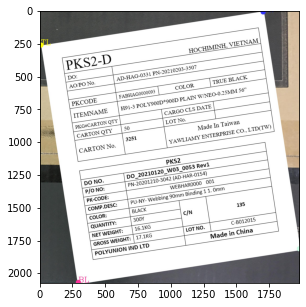

In [ ]:
img = cv2.imread('/content/input/cut_form.jpg')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
gray_mask = np.asarray(mask, dtype=np.uint8) * 255

In [ ]:
np.max(gray_mask)

255

In [ ]:
gray_mask.shape

(3648, 5472)

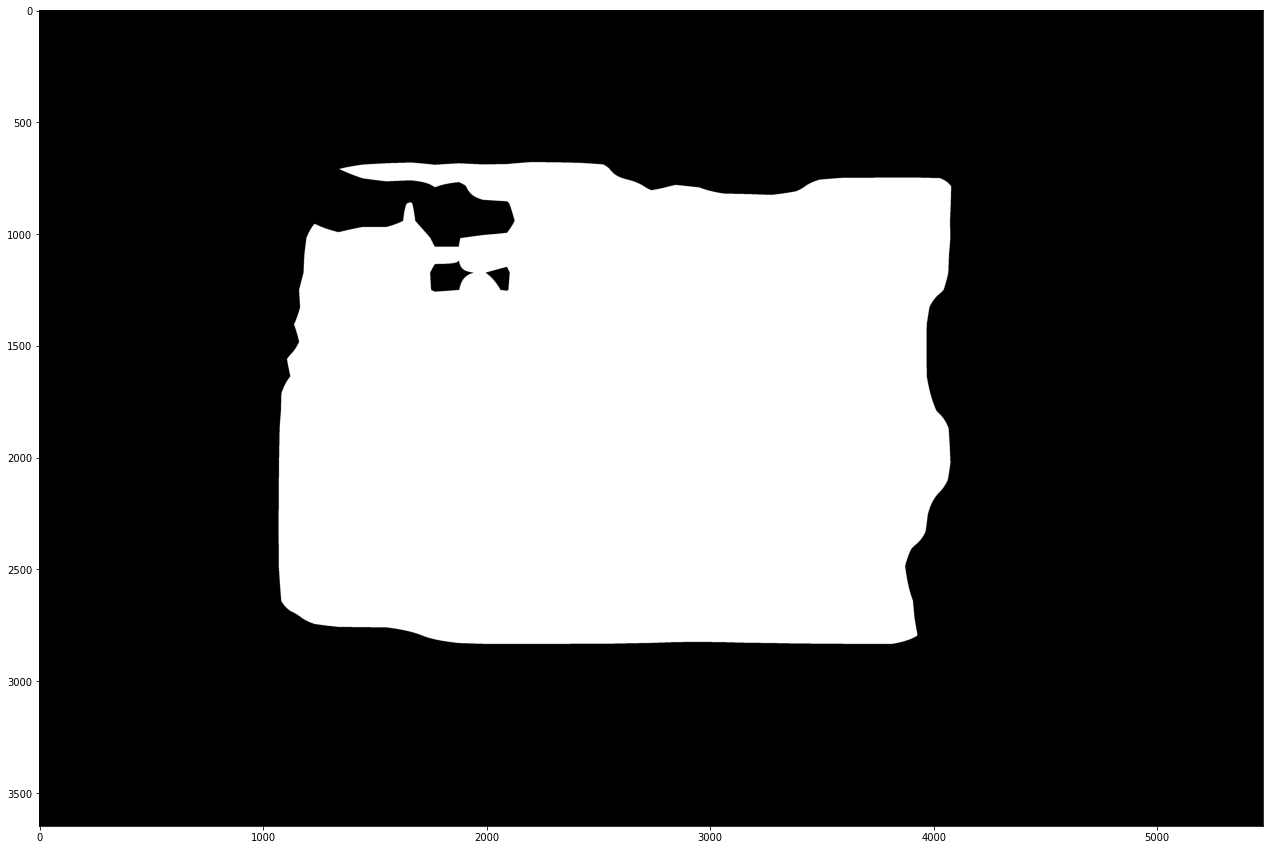

In [ ]:
# mask = cv2.imread('/content/prediction/cut_form.png')
# gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
_, bin_mask = cv2.threshold(gray_mask, 100, 255, cv2.THRESH_BINARY)
plt.imshow(bin_mask, cmap='gray')

In [ ]:
temp_bbox = mask2box(mask)
temp_bbox = temp_bbox.reshape(-1,1,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


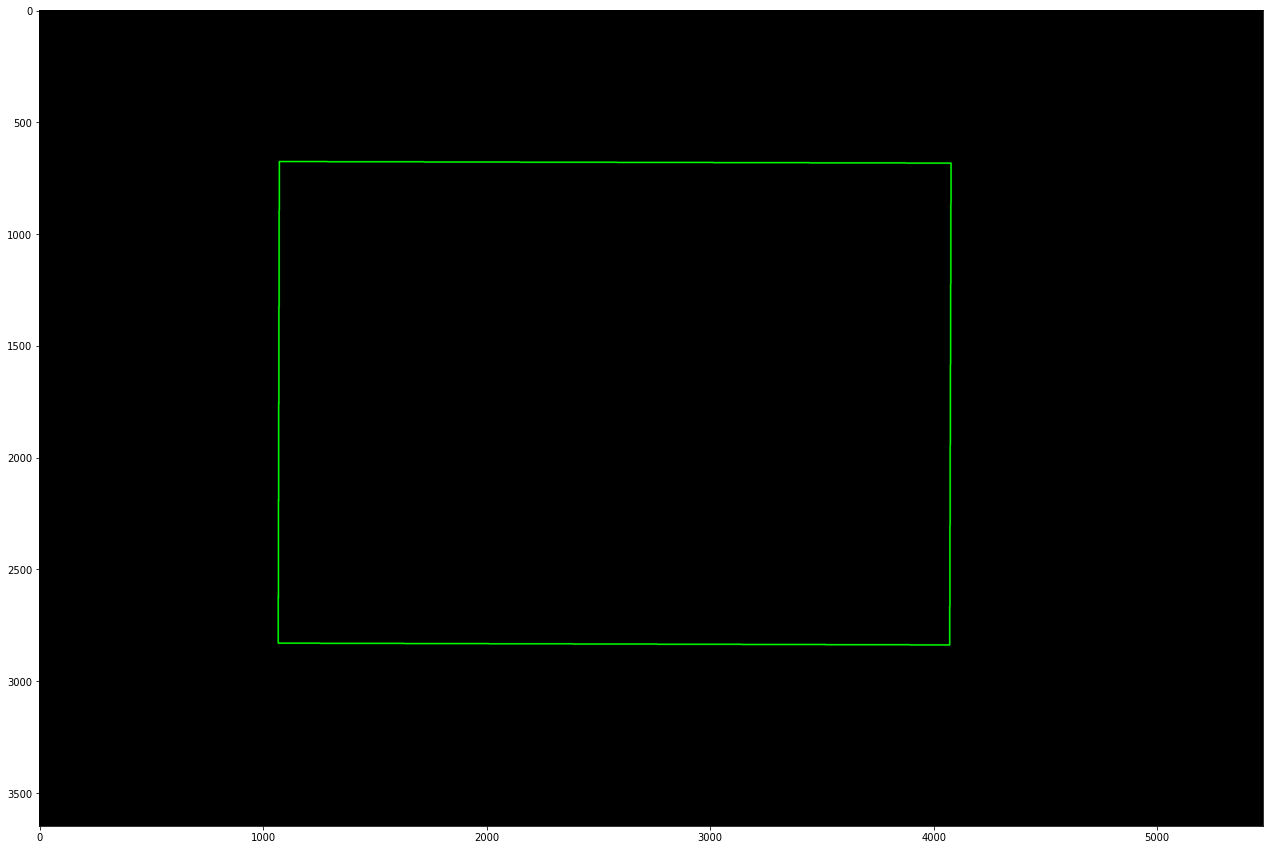

In [ ]:
h,w = mask.shape
result_img = np.zeros((h,w,3))
result_img = cv2.drawContours(result_img, [temp_bbox], -1, (0,255,0), 5)

plt.imshow(result_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


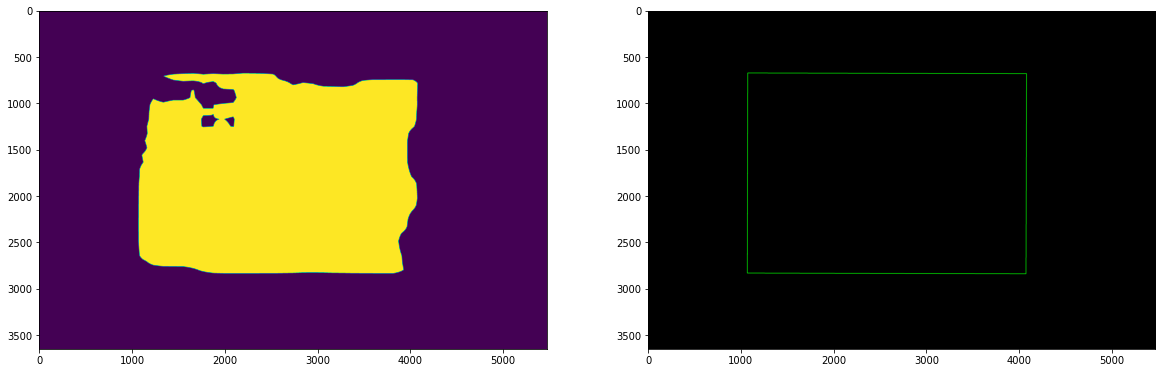

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((20,10))

ax[0].imshow(bin_mask)
ax[1].imshow(result_img)

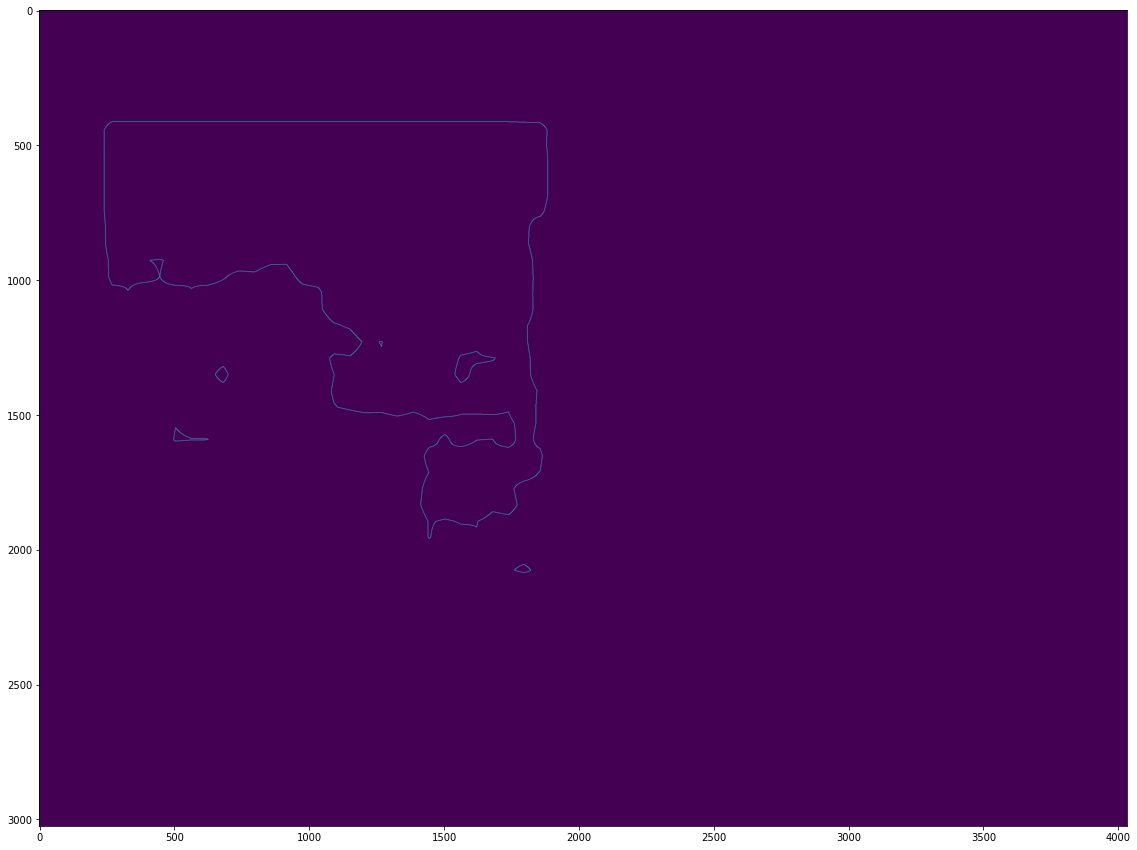

In [ ]:
canny = cv2.Canny(bin_mask, 50, 100)
plt.imshow(canny)

In [ ]:
# tl1 tr1 bl1 br1

# keypoint # tl tr bl br < epsinlon

# 2 3 0 1
# 2 3 0 1
# 3

# 2/4


In [ ]:
cnts, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

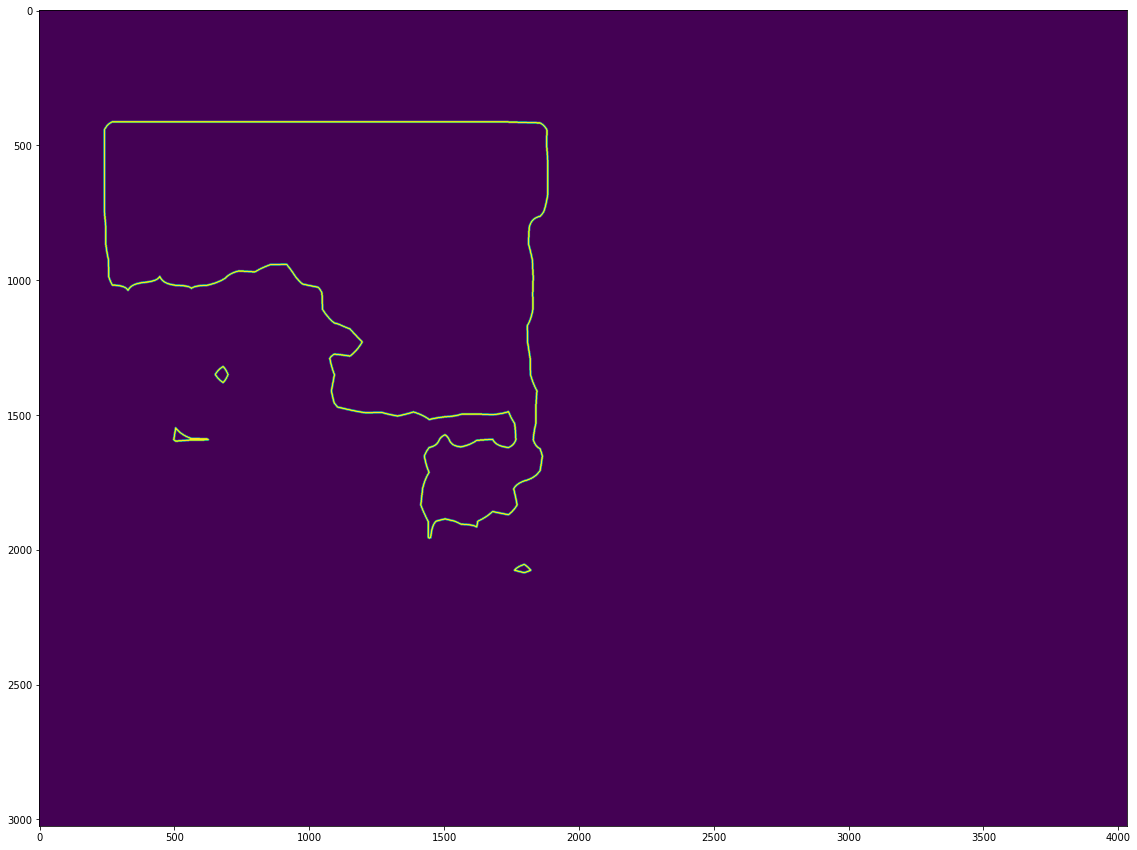

In [ ]:
ret = np.zeros_like(canny)
ret = cv2.drawContours(ret, cnts, -1, (255,255,255), 5)

plt.imshow(ret)

In [ ]:
cnts = np.concatenate(cnts, 0)

In [ ]:
keypoints = prediction['instances'].pred_keypoints[1].cpu().numpy()
keypoints = keypoints[:, :2].astype(np.int32)

In [ ]:
tl, tr, bl, br = matching_keypoint(box, keypoints)

In [ ]:
ret_img = img.copy()
for i, point in enumerate([tl,tr,bl,br]):
  ret_img = cv2.circle(ret_img, tuple(point), 15, COLOR_LIST[i], -1)
  ret_img = cv2.putText(ret_img, TEXT_LIST[i], (point[0], point[1]-10), cv2.FONT_HERSHEY_COMPLEX, 2.5, COLOR_LIST[i], 1)

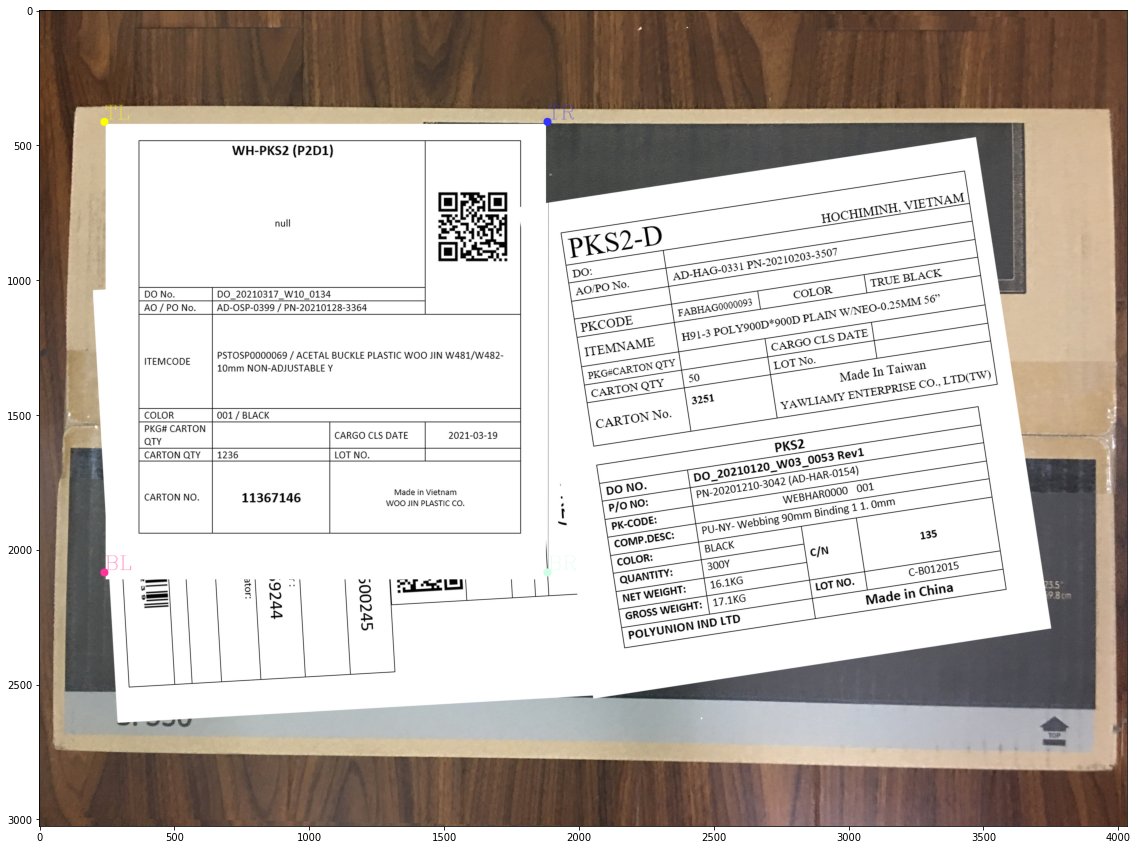

In [ ]:
plt.imshow(ret_img)

In [ ]:
ret = np.zeros_like(canny)
rect = cv2.minAreaRect(cnts)
box = cv2.boxPoints(rect)
box = np.int0(box)

box[:, 0] = np.clip(box[:, 0], a_min=0, a_max=np.max(box[:,0]))
box[:, 1] = np.clip(box[:, 1], a_min=0, a_max=np.max(box[:,1]))
cv2.drawContours(ret,[box],0,(255,255,255),5)

plt.imshow(ret)

In [ ]:
ret_crop_forms = []
for i in range(4):
  ret_crop_form = crop_form(img, [[0,0,img.shape[1], img.shape[0]]], [[box[i], box[(i+1)%4], box[(i+3)%4], box[(i+2)%4]]])
  ret_crop_forms.append(ret_crop_form)

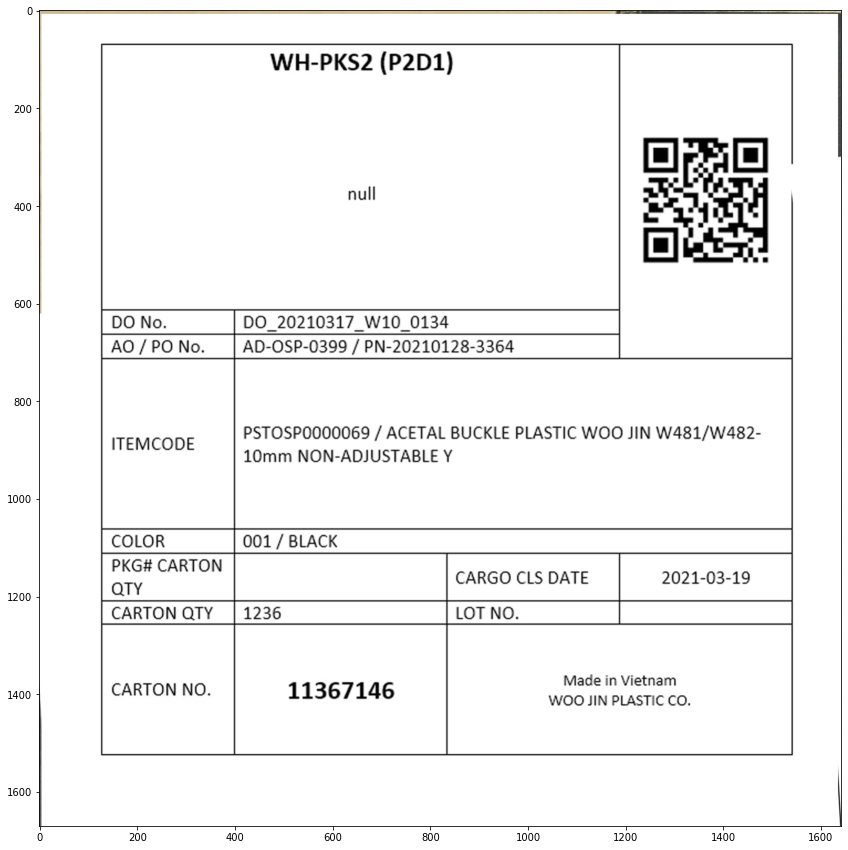

In [ ]:
plt.imshow(ret_crop_forms[1][1])